# XGBOOST Version1
the target of this version is create dynamic features according to specific function

In [ ]:
!pip install xgboost

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## import Libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from typing import List, Dict


## Import data and preprocess for XGBOOST Model

In [12]:
df=pd.read_csv('/content/drive/My Drive/OIL/oildata.csv')

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert Effective date type to datetime
df["DATE"] = pd.to_datetime(df["DATE"])

# Remove timezone from effective date column
# df['DATE'] = pd.to_datetime(df['DATE']).dt.tz_localize(None)
df.head(2)

,DATE,DCOILWTICO
0,2019-05-30,56.47
1,2019-05-31,53.49


In [ ]:
df.head()

,DATE,DCOILWTICO
0,2019-05-30,56.47
1,2019-05-31,53.49
2,2019-06-03,53.25
3,2019-06-04,53.50
4,2019-06-05,51.57


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        1254 non-null   datetime64[ns]
 1   DCOILWTICO  1254 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.7 KB


#### drop duplicate and resample data

In [14]:
# Drop duplicate values before resampling
df = df.drop_duplicates("DATE")

# Set index, resample, and interpolate
df = df.set_index("DATE").resample('D').interpolate(method='linear').reset_index()
# df.set_index('EFFECTIVE_DATE', inplace=True)
df.head(2)


,DATE,DCOILWTICO
0,2019-05-30,56.47
1,2019-05-31,53.49


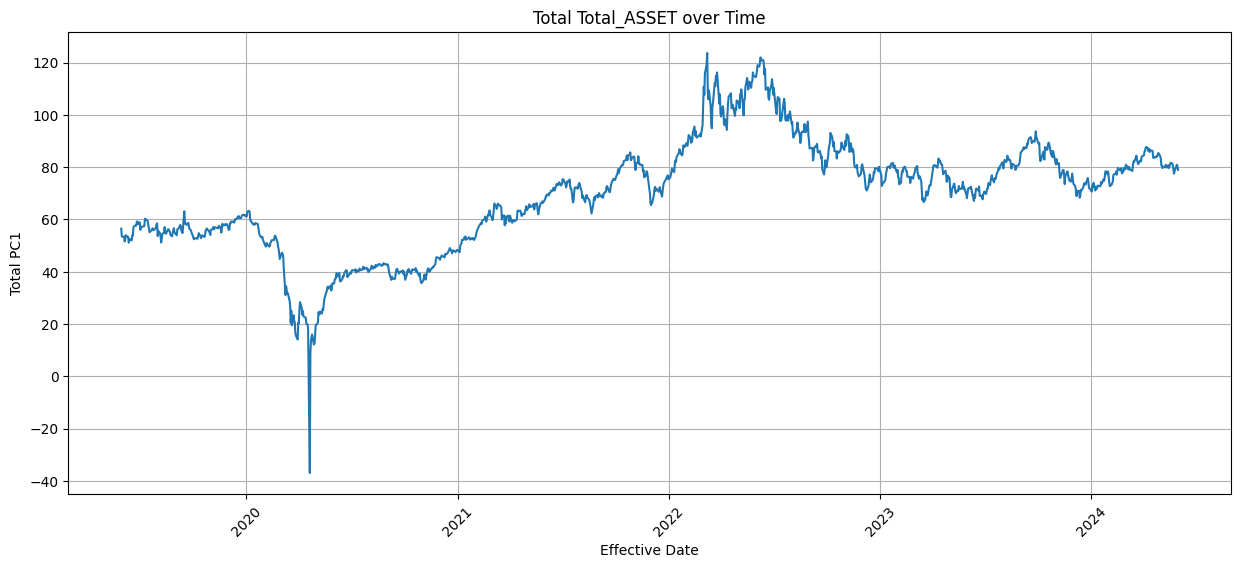

In [7]:
plt.figure(figsize=(15, 6))
plt.plot(df['DATE'], df['DCOILWTICO'], linestyle='-',alpha=1,lw=1.5)
plt.xlabel('Effective Date')
plt.ylabel('Total PC1')
plt.title('Total Total_ASSET over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [15]:

# Define DateFeatures and CyclicalFeatures transformers here
class DateFeatures(TransformerMixin, BaseEstimator):
    """DateFeatures transformer."""
    features = [
        "year",
        "day",
        "weekday",
        "month",
    ]

    def __init__(self):
        """Nothing much to do."""
        super().__init__()
        self.feature_names: List[str] = []

    def get_feature_names(self):
        """Feature names."""
        return self.feature_names

    def transform(self, df: pd.DataFrame):
        """Annotate date features."""
        Xt = []
        for col in df.columns:
            for feature in self.features:
                date_feature = getattr(
                    getattr(
                        df[col], "dt"
                    ), feature
                )
                date_feature.name = f"{col}_{feature}"
                Xt.append(date_feature)

        df2 = pd.concat(Xt, axis=1)
        self.feature_names = list(df2.columns)
        return df2

    def fit(self, df: pd.DataFrame, y=None, **fit_params):
        """No fitting needed."""
        return self

class CyclicalFeatures(TransformerMixin, BaseEstimator):
    """CyclicalFeatures transformer."""

    def __init__(self, max_vals: Dict[str, float] = {}):
        """Nothing much to do."""
        super().__init__()
        self.feature_names: List[str] = []
        self.max_vals = max_vals

    def get_feature_names(self):
        """Feature names."""
        return self.feature_names

    def transform(self, df: pd.DataFrame):
        """Annotate date features."""
        Xt = []
        for col in df.columns:
            if col in self.max_vals:
                max_val = self.max_vals[col]
            else:
                max_val = df[col].max()
            for fun_name, fun in [("cos", np.cos), ("sin", np.sin)]:
                date_feature = fun(2 * np.pi * df[col] / max_val)
                date_feature.name = f"{col}_{fun_name}"
                Xt.append(date_feature)

        df2 = pd.concat(Xt, axis=1)
        self.feature_names = list(df2.columns)
        return df2

    def fit(self, df: pd.DataFrame, y=None, **fit_params):
        """No fitting needed."""
        return self

preprocessor = ColumnTransformer(
    transformers=[
        (
            "DATE",
            make_pipeline(
                DateFeatures(),
                ColumnTransformer(
                    transformers=[
                        ("cyclical", CyclicalFeatures(), ["DATE_day", "DATE_weekday", "DATE_month"])
                    ],
                    remainder="passthrough"
                )
            ),
            ["DATE"],
        )
    ],
    remainder="passthrough"
)

pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        # Add your classifier/regressor here if needed
    ]
)
FEATURE_COLS = ["DATE"]
date_features = pipeline.fit_transform(df[FEATURE_COLS])
date_features


array([[ 9.79529941e-01, -2.01298520e-01, -1.00000000e+00, ...,
        -8.66025404e-01,  5.00000000e-01,  2.01900000e+03],
       [ 1.00000000e+00, -2.44929360e-16, -5.00000000e-01, ...,
        -8.66025404e-01,  5.00000000e-01,  2.01900000e+03],
       [ 9.79529941e-01,  2.01298520e-01,  5.00000000e-01, ...,
        -1.00000000e+00,  1.22464680e-16,  2.01900000e+03],
       ...,
       [ 8.20763441e-01, -5.71268215e-01,  5.00000000e-01, ...,
        -8.66025404e-01,  5.00000000e-01,  2.02400000e+03],
       [ 9.18957812e-01, -3.94355855e-01, -5.00000000e-01, ...,
        -8.66025404e-01,  5.00000000e-01,  2.02400000e+03],
       [ 9.79529941e-01, -2.01298520e-01, -1.00000000e+00, ...,
        -8.66025404e-01,  5.00000000e-01,  2.02400000e+03]])

#### Create Train and test split data

In [16]:
TRAIN_SIZE = int(len(df) * 0.9)
HORIZON = 1
TARGET_COL = "DCOILWTICO"

X_train, X_test = df.iloc[HORIZON:TRAIN_SIZE], df.iloc[TRAIN_SIZE+HORIZON:]
y_train = df.shift(periods=HORIZON).iloc[HORIZON:TRAIN_SIZE][TARGET_COL]
y_test = df.shift(periods=HORIZON).iloc[TRAIN_SIZE+HORIZON:][TARGET_COL]

In [11]:
len(y_test)

182

### Create a pipeline and define XGBOOST Model

In [24]:
alpha = 10
lambda_ = 10.0
from xgboost import XGBRegressor

pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("xgb", XGBRegressor(objective="reg:squarederror",
                              n_estimators=500,
                              max_depth=3,
                              reg_alpha=alpha,   # L1 regularization
                              reg_lambda=lambda_))  # L2 regularization
    ]
)

# Fit the model
pipeline.fit(X_train[FEATURE_COLS], y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('DATE',
                                                  Pipeline(steps=[('datefeatures',
                                                                   DateFeatures()),
                                                                  ('columntransformer',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('cyclical',
                                                                                                    CyclicalFeatures(),
                                                                                                    ['DATE_day',
                                                                                                     'DATE_weekday',
                                                                                                     'DATE_month'])]))]),
                                                  ['DATE'])])),
                ('xgb',
                 XGBRegressor(base_score=None, b...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [30]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions on training data
y_train_pred = pipeline.predict(X_train[FEATURE_COLS])

train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)  # RMSE

y_test_pred = pipeline.predict(X_test[FEATURE_COLS])

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print("The root mean squared error (RMSE) on training set: {:.2f}".format(train_rmse))

# The rest of your code for forecasting and plotting
MAX_HORIZON = 1
X_test_horizon = pd.Series(pd.date_range(
    start=df.DATE.min(),
    periods=len(df) + MAX_HORIZON,
    name="DATE"
)).reset_index()

forecasted = pd.concat(
    [pd.Series(pipeline.predict(X_test_horizon[FEATURE_COLS])), pd.Series(X_test_horizon.DATE)],
    axis=1
)
forecasted.columns = [TARGET_COL, "DATE"]

actual = pd.concat(
    [pd.Series(df[TARGET_COL]), pd.Series(df.DATE)],
    axis=1
)
actual.columns = [TARGET_COL, "DATE"]


# Calculate and print RMSE for the test dataset
test_data = actual.merge(forecasted, on="DATE", suffixes=("_actual", "_predicted"))
mse = mean_squared_error(test_data[TARGET_COL + "_actual"], test_data[TARGET_COL + "_predicted"], squared=False)  # RMSE
print("The root mean squared error (RMSE) on test set: {:.2f}".format(mse))


The root mean squared error (RMSE) on training set: 3.16
The root mean squared error (RMSE) on test set: 3.57


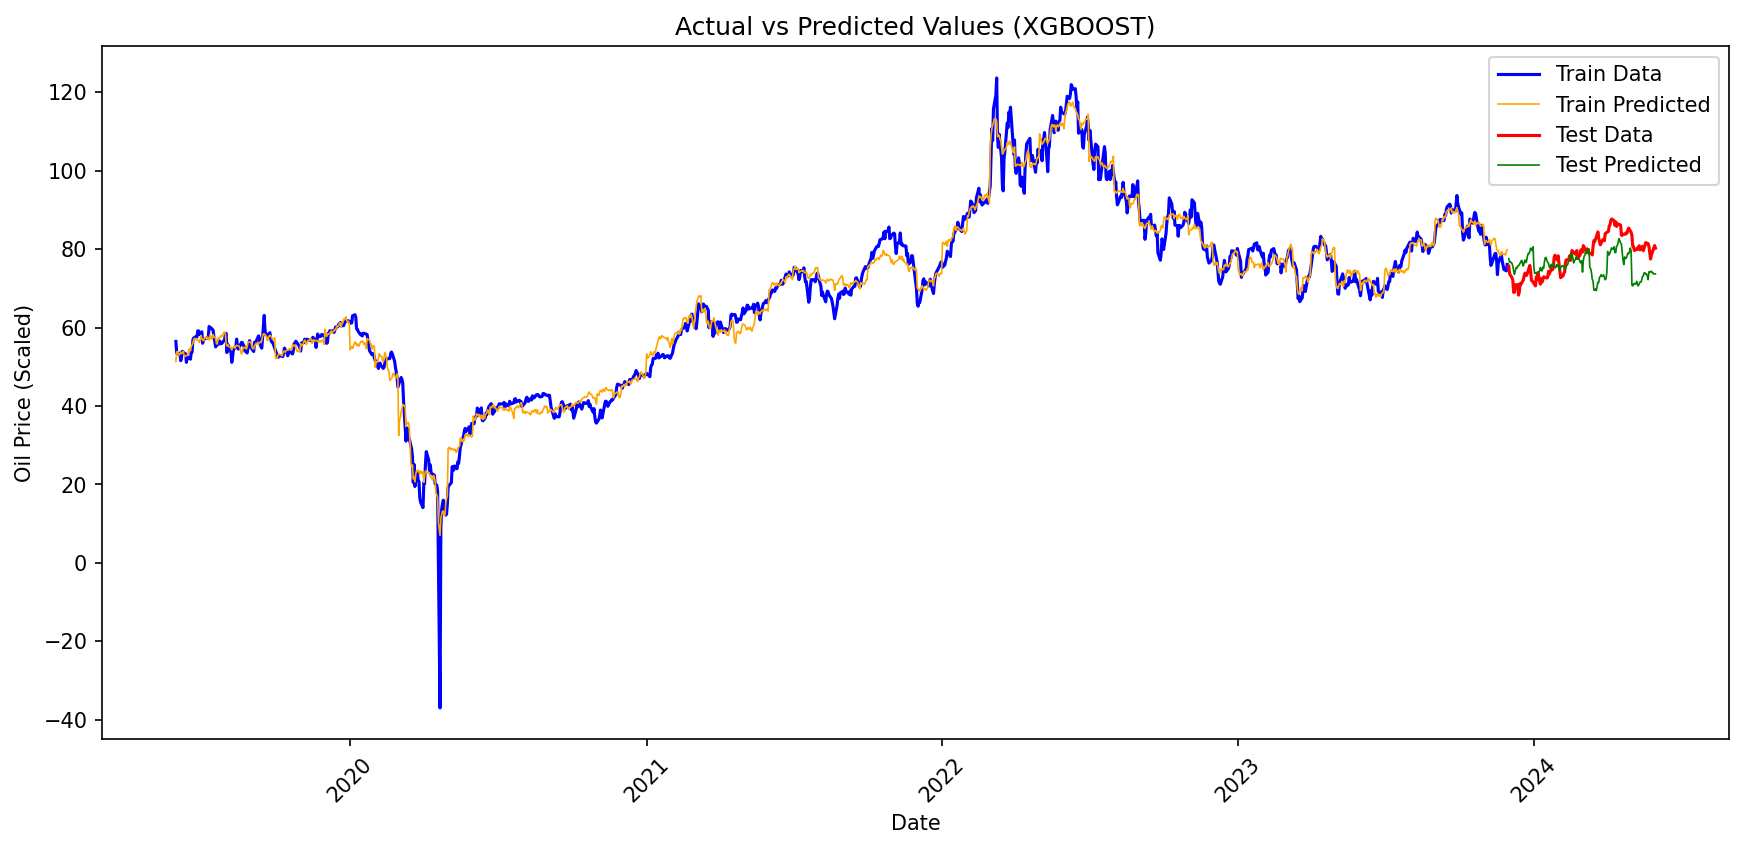

The root mean squared error (RMSE) on training set: 3.16
The root mean squared error (RMSE) on test set: 5.91


In [33]:
import matplotlib.pyplot as plt

# Assuming 'DATE' column in df holds the date values
train_dates = X_train['DATE']
test_dates = X_test['DATE']

plt.figure(figsize=(14, 6), dpi=150)

plt.plot(train_dates, y_train, label='Train Data', color='blue')

plt.plot(train_dates, y_train_pred, label='Train Predicted', color='orange', linewidth=0.8)

plt.plot(test_dates, y_test, label='Test Data', color='red')

plt.plot(test_dates, y_test_pred, label='Test Predicted', color='green', linewidth=0.8)

plt.title('Actual vs Predicted Values (XGBOOST)')
plt.xlabel('Date')
plt.ylabel('Oil Price (Scaled)')

plt.legend()

plt.xticks(rotation=45)

plt.show()

